<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions
# 第7章：指令微调

In [1]:
# 从importlib.metadata导入version函数用于获取包版本信息
from importlib.metadata import version

# 定义需要检查版本的包列表
pkgs = [
    "matplotlib",  # 绘图库
    "tiktoken",    # 分词器
    "torch",       # 深度学习库
    "tqdm",        # 进度条
    "tensorflow",  # 用于加载OpenAI的预训练权重
]

# 遍历包列表并打印每个包的版本号
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
tiktoken version: 0.8.0
torch version: 2.5.0
tqdm version: 4.66.5
tensorflow version: 2.18.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=500px>

## 7.1 Introduction to instruction finetuning
## 7.1 指令微调简介

- In chapter 5, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- 在第5章中,我们看到预训练LLM涉及一个训练过程,模型学会一次生成一个词
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions  
- 因此,预训练的LLM擅长文本补全,但不擅长遵循指令
- In this chapter, we teach the LLM to follow instructions better
- 在本章中,我们将教会LLM更好地遵循指令

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>

- The topics covered in this chapter are summarized in the figure below
- 本章涵盖的主题总结在下图中

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=500px>

## 7.2 Preparing a dataset for supervised instruction finetuning
## 7.2 准备用于监督指令微调的数据集

- We will work with an instruction dataset I prepared for this chapter
- 我们将使用我为本章准备的指令数据集

In [2]:
# 导入所需的模块
import json  # 用于处理JSON数据
import os    # 用于文件和路径操作
import urllib  # 用于URL请求


def download_and_load_file(file_path, url):
    """
    下载并加载JSON文件
    
    参数:
        file_path: 本地文件保存路径
        url: 远程文件URL
    返回:
        解析后的JSON数据
    """
    # 如果文件不存在则下载
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        # 将下载的数据写入文件
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        # 如果文件存在则直接读取
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    # 解析JSON数据
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


# 设置文件路径和URL
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

# 下载并加载数据
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form
- 我们从上面的JSON文件加载的`data`列表中的每一项都是以下形式的字典

In [3]:
# 打印第50个数据条目作为示例
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:
- 注意 `'input'` 字段可以为空:

In [4]:
# 打印第999个数据条目作为另一个示例
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- 指令微调通常被称为"有监督指令微调"，因为它涉及在输入-输出对明确提供的数据集上训练模型

- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively
- 有多种方式可以将条目格式化为LLM的输入；下图展示了两个示例格式，分别用于训练Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) 和 Phi-3 (https://arxiv.org/abs/2404.14219) LLM模型

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>

- In this chapter, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- 在本章中，我们使用Alpaca风格的提示格式，这是指令微调的原始提示模板
- Below, we format the input that we will pass as input to the LLM
- 下面，我们将格式化作为输入传递给LLM的输入内容

In [5]:
def format_input(entry):
    # 构建指令文本,包含任务描述和指令内容
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 如果存在输入字段,则添加输入文本,否则为空字符串
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    # 返回完整的格式化文本(指令文本+输入文本)
    return instruction_text + input_text

- A formatted response with input field looks like as shown below
- 带有输入字段的格式化响应如下所示

In [6]:
# 格式化第50个数据条目作为模型输入
model_input = format_input(data[50])
# 构建期望的响应文本
desired_response = f"\n\n### Response:\n{data[50]['output']}"

# 打印完整的输入-输出对
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- Below is a formatted response without an input field
- 下面是一个不带输入字段的格式化响应

In [7]:
# 格式化第999个数据条目作为模型输入
model_input = format_input(data[999])
# 构建期望的响应文本
desired_response = f"\n\n### Response:\n{data[999]['output']}"

# 打印完整的输入-输出对
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- Lastly, before we prepare the PyTorch data loaders in the next section, we divide the dataset into a training, validation, and test set
- 最后,在我们准备下一节的PyTorch数据加载器之前,我们将数据集划分为训练集、验证集和测试集

In [8]:
# 计算训练集大小(总数据的85%)
train_portion = int(len(data) * 0.85)  # 85%用于训练

# 计算测试集大小(总数据的10%) 
test_portion = int(len(data) * 0.1)    # 10%用于测试

# 计算验证集大小(剩余5%)
val_portion = len(data) - train_portion - test_portion  # 剩余5%用于验证

# 划分训练集
train_data = data[:train_portion]

# 划分测试集
test_data = data[train_portion:train_portion + test_portion]

# 划分验证集
val_data = data[train_portion + test_portion:]

In [9]:
# 打印训练集大小
print("Training set length:", len(train_data))
# 打印验证集大小
print("Validation set length:", len(val_data))
# 打印测试集大小
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches
## 7.3 组织数据为训练批次

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>

- We tackle this dataset batching in several steps, as summarized in the figure below
- 我们将分几个步骤处理这个数据集的批处理,如下图所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=500px>

- First, we implement an `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` in chapter 6
- 首先,我们实现一个`InstructionDataset`类来预先对数据集中的所有输入进行分词,类似于第6章中的`SpamDataset`类

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=500px>

In [10]:
# 导入PyTorch相关模块
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    """指令数据集类,用于预处理和存储指令微调数据"""
    def __init__(self, data, tokenizer):
        # 存储原始数据
        self.data = data

        # 预先对文本进行分词处理
        self.encoded_texts = []
        for entry in data:
            # 格式化指令和输入文本
            instruction_plus_input = format_input(entry) 
            # 添加响应文本
            response_text = f"\n\n### Response:\n{entry['output']}"
            # 合并完整文本
            full_text = instruction_plus_input + response_text
            # 对文本进行分词并存储
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        """返回指定索引的编码文本"""
        return self.encoded_texts[index]

    def __len__(self):
        """返回数据集大小"""
        return len(self.data)

- Similar to chapter 6, we want to collect multiple training examples in a batch to accelerate training; this requires padding all inputs to a similar length
- 类似于第6章,我们希望在一个批次中收集多个训练样本以加速训练;这需要将所有输入填充到相似的长度
- Also similar to the previous chapter, we use the `<|endoftext|>` token as a padding token
- 同样类似于前一章,我们使用`<|endoftext|>`标记作为填充标记

In [11]:
# 导入tiktoken库用于分词
import tiktoken

# 获取GPT-2的分词器
tokenizer = tiktoken.get_encoding("gpt2")

# 打印<|endoftext|>标记的编码ID
# allowed_special参数指定允许编码的特殊标记
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- In chapter 6, we padded all examples in a dataset to the same length
- 在第6章中,我们将数据集中的所有样本填充到相同的长度
  - Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
  - 在这里,我们采用更复杂的方法,开发一个自定义的"collate"函数,可以传递给数据加载器
  - This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)
  - 这个自定义的collate函数将每个批次中的训练样本填充到相同的长度(但不同批次可以有不同的长度)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256, 
    device="cpu"
):
    """自定义的collate函数,用于将批次中的序列填充到相同长度
    
    参数:
        batch: 包含多个序列的批次
        pad_token_id: 填充标记的ID,默认为50256 (<|endoftext|>)
        device: 计算设备,默认为CPU
        
    返回:
        inputs_tensor: 填充后的输入张量
    """
    # 找到批次中最长序列的长度
    # 并将最大长度+1,这将在下面添加一个额外的填充标记
    batch_max_length = max(len(item)+1 for item in batch)

    # 填充并准备输入
    inputs_lst = []

    for item in batch:
        # 复制序列以避免修改原始数据
        new_item = item.copy()
        # 添加<|endoftext|>标记
        new_item += [pad_token_id]
        # 将序列填充到batch_max_length长度
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 通过padded[:-1]移除通过batch_max_length中的+1设置添加的额外填充标记
        # (额外的填充标记将在后续代码中使用)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # 将输入列表转换为张量并传输到目标设备
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
# 创建三个不同长度的输入序列
inputs_1 = [0, 1, 2, 3, 4]  # 长度为5的序列
inputs_2 = [5, 6]          # 长度为2的序列
inputs_3 = [7, 8, 9]       # 长度为3的序列

# 将三个序列组合成一个批次
batch = (
    inputs_1,
    inputs_2, 
    inputs_3
)

# 使用custom_collate_draft_1函数处理批次
# 该函数会将所有序列填充到相同长度并返回张量
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>

- Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
- 上面我们只返回了LLM的输入;然而,对于LLM训练,我们还需要目标值
- Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token
- 与预训练LLM类似,目标值是将输入向右移动1个位置,这样LLM就能学会预测下一个token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

In [14]:
def custom_collate_draft_2(
    batch,           # 输入的批次数据
    pad_token_id=50256,  # 填充标记ID,默认为50256
    device="cpu"     # 设备类型,默认为CPU
):
    # 找出批次中最长序列的长度(加1是为了添加结束标记)
    batch_max_length = max(len(item)+1 for item in batch)

    # 初始化用于存储输入和目标的列表
    inputs_lst, targets_lst = [], []

    for item in batch:
        # 复制输入项以避免修改原始数据
        new_item = item.copy()
        # 在序列末尾添加结束标记
        new_item += [pad_token_id]
        # 使用填充标记将序列填充到最大长度
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 创建输入张量,去掉最后一个标记
        inputs = torch.tensor(padded[:-1])  
        # 创建目标张量,向右移动一个位置
        targets = torch.tensor(padded[1:])  
        # 将处理后的序列添加到相应的列表中
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 将输入和目标列表转换为张量,并移至指定设备
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    # 返回输入张量和目标张量
    return inputs_tensor, targets_tensor

In [15]:
# 使用custom_collate_draft_2函数处理批次数据
# 返回输入张量和目标张量
inputs, targets = custom_collate_draft_2(batch)
# 打印输入张量
print(inputs)
# 打印目标张量
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- Next, we introduce an `ignore_index` value to replace all padding token IDs with a new value; the purpose of this `ignore_index` is that we can ignore padding values in the loss function (more on that later)
- 接下来,我们引入一个`ignore_index`值来替换所有的填充标记ID;这个`ignore_index`的目的是让我们可以在损失函数中忽略填充值(稍后会详细介绍)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=500px>

 - Concretely, this means that we replace the token IDs corresponding to `50256` with `-100` as illustrated below
 - 具体来说,这意味着我们将对应于`50256`的标记ID替换为`-100`,如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- (In addition, we also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)
- (此外,我们还引入了`allowed_max_length`参数,以便在需要时限制样本长度;如果你计划使用的自定义数据集长度超过GPT-2模型支持的1024个标记的上下文大小,这个参数会很有用)

In [16]:
# 定义自定义的数据批次处理函数
def custom_collate_fn(
    batch,                      # 输入的数据批次
    pad_token_id=50256,        # 填充标记ID,默认为50256
    ignore_index=-100,         # 忽略索引值,默认为-100
    allowed_max_length=None,   # 允许的最大序列长度,默认为None
    device="cpu"               # 设备类型,默认为CPU
):
    # 找出批次中最长序列的长度(加1是为了后面添加结束标记)
    batch_max_length = max(len(item)+1 for item in batch)

    # 初始化用于存储输入和目标的列表
    inputs_lst, targets_lst = [], []

    # 遍历批次中的每个样本
    for item in batch:
        # 复制当前样本以避免修改原始数据
        new_item = item.copy()
        # 在序列末尾添加结束标记
        new_item += [pad_token_id]
        # 使用填充标记将序列填充到最大长度
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 创建输入张量,去掉最后一个标记
        inputs = torch.tensor(padded[:-1])  
        # 创建目标张量,向右移动一个位置
        targets = torch.tensor(padded[1:])  

        # 在目标张量中找出所有填充标记的位置
        mask = targets == pad_token_id
        # 获取填充标记的索引位置
        indices = torch.nonzero(mask).squeeze()
        # 如果有多个填充标记,将第一个之后的所有填充标记替换为ignore_index
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # 如果指定了最大长度限制,则截断序列
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        # 将处理后的输入和目标添加到对应的列表中
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 将输入和目标列表堆叠成张量,并移至指定设备
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    # 返回处理后的输入和目标张量
    return inputs_tensor, targets_tensor

In [17]:
# 使用自定义的collate函数处理批次数据
inputs, targets = custom_collate_fn(batch)
# 打印输入张量
print(inputs)
# 打印目标张量
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- Let's see what this replacement by -100 accomplishes
让我们看看用-100替换会产生什么效果

- For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1, similar to chapter 6 
为了说明问题,让我们假设有一个小型分类任务,包含0和1两个类别标签,类似于第6章

- If we have the following logits values (outputs of the last layer of the model), we calculate the following loss
如果我们有以下logits值(模型最后一层的输出),我们计算如下损失

In [18]:
# 创建一个包含两个训练样本的logits张量
# 每个样本有两个类别的预测分数
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 第一个训练样本
     [-0.5, 1.5]]  # 第二个训练样本
)

# 创建对应的目标标签张量
# 0表示第一个类别,1表示第二个类别
targets_1 = torch.tensor([0, 1])

# 使用交叉熵损失函数计算损失
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
# 打印计算得到的损失值
print(loss_1)

tensor(1.1269)


- Now, adding one more training example will, as expected, influence the loss
- 现在,按预期添加一个训练样本会影响损失值

In [19]:
# 创建一个包含三个训练样本的logits张量
# 每个样本有两个类别的预测分数
logits_2 = torch.tensor(
    [[-1.0, 1.0],   # 第一个训练样本
     [-0.5, 1.5],   # 第二个训练样本  
     [-0.5, 1.5]]   # 第三个训练样本
)

# 创建对应的目标标签张量
# 0表示第一个类别,1表示第二个类别
targets_2 = torch.tensor([0, 1, 1])

# 使用交叉熵损失函数计算损失
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
# 打印计算得到的损失值
print(loss_2)

tensor(0.7936)


 - Let's see what happens if we replace the class label of one of the examples with -100
 - 让我们看看如果将其中一个样本的类别标签替换为-100会发生什么

In [20]:
# 创建一个目标标签张量,其中最后一个样本的标签为-100
targets_3 = torch.tensor([0, 1, -100])

# 使用交叉熵损失函数计算损失,会忽略标签为-100的样本
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
# 打印计算得到的损失值
print(loss_3)
# 打印loss_3是否等于loss_1的比较结果
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
- 正如我们所见,这3个训练样本的损失值与我们从2个训练样本计算得到的损失值相同,这意味着交叉熵损失函数忽略了标签为-100的训练样本
- By default, PyTorch has the `cross_entropy(..., ignore_index=-100)` setting to ignore examples corresponding to the label -100
- 默认情况下,PyTorch的`cross_entropy(..., ignore_index=-100)`设置会忽略标签为-100的样本
- Using this -100 `ignore_index`, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- 使用这个-100的`ignore_index`,我们可以忽略用于将训练样本填充到相同长度的批次中的额外文本结束(padding)标记
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete
- 但是,我们不想忽略文本结束(padding)标记(50256)的第一个实例,因为它可以帮助向LLM发出响应完成的信号

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)
- 在实践中,屏蔽与指令相对应的目标标记ID也是很常见的做法,如下图所示(这是完成本章后推荐读者练习的内容)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

## 7.4 Creating data loaders for an instruction dataset
## 7.4 为指令数据集创建数据加载器

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders
- 在本节中,我们使用`InstructionDataset`类和`custom_collate_fn`函数来实例化训练、验证和测试数据加载器

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- Another additional detail of the previous `custom_collate_fn` function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the `custom_collate_fn` as part of the data loader
- 之前的`custom_collate_fn`函数的另一个细节是,我们现在直接将数据移动到目标设备(例如GPU),而不是在主训练循环中进行,这提高了效率,因为当我们使用`custom_collate_fn`作为数据加载器的一部分时,它可以作为后台进程执行
- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled
- 使用Python的`functools`标准库中的`partial`函数,我们创建一个新函数,其中原始函数的`device`参数已预先填充

In [21]:
# 设置设备为GPU(如果可用)或CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 注意:
# 取消注释以下代码可以在Apple Silicon芯片上运行(如果适用),
# 这比在Apple CPU上运行要快得多(在M3 MacBook Air上测试)。
# 但是,得到的损失值可能会略有不同。

#if torch.cuda.is_available():
#    device = torch.device("cuda") 
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

# 打印使用的设备
print("Device:", device)

Device: cpu


In [22]:
# 从functools导入partial函数用于创建偏函数
from functools import partial

# 使用partial创建一个新的collate函数
# 预设device参数为当前设备,最大序列长度为1024
customized_collate_fn = partial(
    custom_collate_fn,
    device=device, 
    allowed_max_length=1024
)

- Next, we instantiate the data loaders similar to previous chapters, except that we now provide our own collate function for the batching process
- 接下来,我们实例化数据加载器,与前几章类似,但现在我们为批处理过程提供了自己的collate函数

In [23]:
# 从torch.utils.data导入DataLoader类
from torch.utils.data import DataLoader


# 设置工作进程数为0(不使用多进程)
num_workers = 0
# 设置每个批次的大小为8
batch_size = 8

# 设置随机种子以确保可重复性
torch.manual_seed(123)

# 使用训练数据和分词器创建指令数据集
train_dataset = InstructionDataset(train_data, tokenizer)
# 创建训练数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,        # 每批次8个样本
    collate_fn=customized_collate_fn,  # 使用自定义的收集函数
    shuffle=True,                 # 随机打乱数据
    drop_last=True,              # 丢弃最后不完整的批次
    num_workers=num_workers      # 不使用多进程加载
)

In [24]:
# 使用验证数据和分词器创建指令数据集
val_dataset = InstructionDataset(val_data, tokenizer)
# 创建验证数据加载器
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,        # 每批次8个样本
    collate_fn=customized_collate_fn,  # 使用自定义的收集函数
    shuffle=False,                # 不打乱数据顺序
    drop_last=False,             # 保留最后不完整的批次
    num_workers=num_workers      # 不使用多进程加载
)

# 使用测试数据和分词器创建指令数据集
test_dataset = InstructionDataset(test_data, tokenizer)
# 创建测试数据加载器
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,        # 每批次8个样本
    collate_fn=customized_collate_fn,  # 使用自定义的收集函数
    shuffle=False,                # 不打乱数据顺序
    drop_last=False,             # 保留最后不完整的批次
    num_workers=num_workers      # 不使用多进程加载
)

- Let's see what the dimensions of the resulting input and target batches look like
- 让我们看看生成的输入和目标批次的维度是什么样的

In [25]:
# 打印训练数据加载器的信息
print("Train loader:")
# 遍历训练数据加载器,获取每个批次的输入和目标
for inputs, targets in train_loader:
    # 打印每个批次输入和目标张量的形状
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
- 从上面的输出可以看出,所有批次的大小都是8,但长度不同,这是符合预期的
- Let's also double-check that the inputs contain the `<|endoftext|>` padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the `inputs` batch
- 让我们通过打印第一个训练样本的内容来再次检查输入是否包含对应于token ID 50256的`<|endoftext|>`填充标记

In [26]:
# 打印第一个训练样本的内容
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])


 - Similarly, we visually double-check that the targets contain the -100 placeholder tokens
- 同样,我们通过可视化检查目标是否包含-100占位符标记

In [27]:
# 打印第一个目标样本
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])


## 7.5 Loading a pretrained LLM
## 7.5 加载预训练的大语言模型

- In this section, we load a pretrained GPT model using the same code that we used in section 5.5 of chapter 5 and section 6.4 in chapter 6
- 在本节中,我们使用第5章第5.5节和第6章第6.4节中使用的相同代码加载预训练的GPT模型

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>

- However, instead of loading the smallest 124 million parameter model, we load the medium version with 355 million parameters since the 124 million model is too small for achieving qualitatively reasonable results via instruction finetuning
- 然而,我们不加载最小的1.24亿参数模型,而是加载具有3.55亿参数的中等版本,因为1.24亿模型太小,无法通过指令微调获得定性合理的结果

In [28]:
# 导入所需的模块
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


# 基础配置字典
BASE_CONFIG = {
    "vocab_size": 50257,     # 词汇表大小
    "context_length": 1024,  # 上下文长度
    "drop_rate": 0.0,        # Dropout比率
    "qkv_bias": True         # 是否使用Query-Key-Value偏置
}

# 不同GPT-2模型配置
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},    # 小型模型(1.24亿参数)
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},  # 中型模型(3.55亿参数)
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},   # 大型模型(7.74亿参数)
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},     # 超大型模型(15.58亿参数)
}

# 选择要使用的模型
CHOOSE_MODEL = "gpt2-medium (355M)"

# 更新基础配置
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# 提取模型大小信息
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

# 下载并加载预训练模型参数
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

# 初始化模型并加载参数
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();  # 将模型设置为评估模式

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 58.2kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 588kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 49.8kiB/s]
model.ckpt.data-00000-of-00001:   2%|▏         | 31.0M/1.42G [01:33<31:41, 730kiB/s]   

- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks
- 在我们开始下一节的模型微调之前,让我们看看它在其中一个验证任务上的表现如何

In [29]:
# 设置随机种子以确保结果可重现
torch.manual_seed(123)

# 格式化第一个验证数据样本作为输入文本
input_text = format_input(val_data[0])
# 打印格式化后的输入文本
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [30]:
# 从之前的章节导入所需函数
from previous_chapters import (
    generate,
    text_to_token_ids, 
    token_ids_to_text
)

# 使用模型生成文本
token_ids = generate(
    model=model,  # 使用已加载的GPT模型
    idx=text_to_token_ids(input_text, tokenizer),  # 将输入文本转换为token ID
    max_new_tokens=35,  # 最多生成35个新token
    context_size=BASE_CONFIG["context_length"],  # 使用配置中的上下文长度
    eos_id=50256,  # 结束符token ID
)

# 将生成的token ID转换回文本
generated_text = token_ids_to_text(token_ids, tokenizer)

- Note that the `generate` function we used in previous chapters returns the combined input and output text, which was convenient in the previous section for creating legible text
- 请注意,我们在前几章中使用的`generate`函数会返回组合的输入和输出文本,这在前一节创建可读文本时很方便
- To isolate the response, we can subtract the length of the instruction from the start of the `generated_text`
- 为了单独获取响应,我们可以从`generated_text`的开头减去指令的长度

In [31]:
# 从生成的文本中提取响应部分:
# 1. 去掉输入文本部分(通过切片)
# 2. 移除"### Response:"标记
# 3. 去除首尾空白字符
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction
- 正如我们所见，模型目前还无法遵循指令；它虽然创建了"Response"部分，但仅仅是重复了原始输入句子和指令

## 7.6 Finetuning the LLM on instruction data
## 7.6 在指令数据上微调大语言模型

- In this section, we finetune the model
- 在本节中,我们将对模型进行微调

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=500px>

- Note that we can reuse all the loss calculation and training functions that we used in previous chapters
- 请注意,我们可以重用之前章节中使用的所有损失计算和训练函数

In [32]:
# 从前几章导入必要的函数:
# - calc_loss_loader: 用于计算损失
# - train_model_simple: 用于模型训练
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- Let's calculate the initial training and validation set loss before we start training (as in previous chapters, the goal is to minimize the loss)
- 让我们在开始训练之前先计算初始的训练集和验证集损失(与前几章一样,目标是最小化损失)

In [33]:
# 将模型移到指定设备(CPU/GPU)
model.to(device)

# 设置随机种子以确保可重复性
torch.manual_seed(123)

# 在不计算梯度的情况下计算初始损失
with torch.no_grad():
    # 计算训练集损失(使用5个batch)
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    # 计算验证集损失(使用5个batch) 
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

# 打印训练和验证损失
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.82590970993042
Validation loss: 3.761933755874634


- Note that the training is a bit more expensive than in previous chapters since we are using a larger model (355 million instead of 124 million parameters)
- 请注意,由于我们使用了更大的模型(3.55亿参数而不是1.24亿参数),训练比之前章节更耗时
- The runtimes for various devices are shown for reference below (running this notebook on a compatible GPU device requires no changes to the code)
- 下面列出了各种设备的运行时间供参考(在兼容的GPU设备上运行此notebook不需要对代码做任何更改)

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model
- 我使用了 `"gpt2-medium (355M)"` 模型运行此notebook

In [34]:
# 导入时间模块用于计时
import time

# 记录开始时间
start_time = time.time()

# 设置随机种子以确保可重复性
torch.manual_seed(123)

# 初始化AdamW优化器,设置学习率和权重衰减
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

# 设置训练轮数
num_epochs = 2

# 训练模型并获取训练损失、验证损失和已处理的token数
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

# 记录结束时间并计算总训练时间(分钟)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

- As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values
- 从上面的输出可以看出，模型训练良好，这一点从不断下降的训练损失和验证损失值可以看出
- Furthermore, based on the response text printed after each epoch, we can see that the model correctly follows the instruction to convert the input sentence `'The chef cooks the meal every day.'` into passive voice `'The meal is cooked every day by the chef.'` (We will properly format and evaluate the responses in a later section)
- 此外，根据每个训练周期后打印的响应文本，我们可以看到模型正确地遵循了指令，将输入句子`'The chef cooks the meal every day.'`转换为被动语态`'The meal is cooked every day by the chef.'`（我们将在后面的章节中正确格式化和评估这些响应）
- Finally, let's take a look at the training and validation loss curves
- 最后，让我们看看训练损失和验证损失曲线

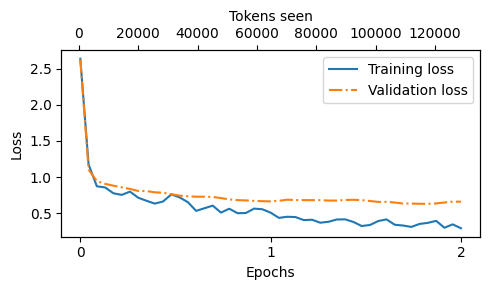

In [35]:
# 从之前的章节导入绘图函数
from previous_chapters import plot_losses

# 创建一个表示训练轮数的张量,从0到num_epochs,长度与train_losses相同
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# 绘制训练损失和验证损失曲线
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- As we can see, the loss decreases sharply at the beginning of the first epoch, which means the model starts learning quickly
- 从图中可以看出,在第一个训练周期开始时损失值急剧下降,这意味着模型开始快速学习
- We can see that slight overfitting sets in at around 1 training epoch  
- 我们可以看到在大约1个训练周期时开始出现轻微的过拟合

## 7.7 Extracting and saving responses
## 7.7 提取和保存响应

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>

- In this section, we save the test set responses for scoring in the next section
- 在本节中,我们保存测试集响应以便在下一节中进行评分
- We also save a copy of the model for future use
- 我们还保存一份模型副本以供将来使用
- But first, let's take a brief look at the responses generated by the finetuned model
- 但首先,让我们简要看一下经过微调的模型生成的响应

In [36]:
# 设置随机种子以确保结果可重现
torch.manual_seed(123)


# 遍历测试数据的前3个样本
for entry in test_data[:3]:

    # 格式化输入文本
    input_text = format_input(entry)

    # 使用模型生成响应
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    # 将生成的token转换回文本
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 提取响应部分并清理格式
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    # 打印输入文本、正确响应和模型响应进行对比
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well
- 从测试集指令、给定响应和模型响应来看，模型表现相对较好

- The answers to the first and last instructions are clearly correct
- 对第一个和最后一个指令的回答明显是正确的

- The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)
- 第二个答案接近正确；模型回答"积云"而不是"积雨云"（但请注意，积云可以发展成积雨云，后者能够产生雷暴）

- Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy
- 最重要的是，我们可以看到模型评估不像上一章那样直接，在上一章中我们只需要计算正确的垃圾邮件/非垃圾邮件类标签的百分比来获得分类准确率

- In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches
- 在实践中，像聊天机器人这样的指令微调LLM通过多种方法进行评估

  - short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)), which test the knowledge of a model
  - 简答和多选基准测试，如MMLU（"测量大规模多任务语言理解"，[https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)），用于测试模型的知识

  - human preference comparison to other LLMs, such as LMSYS chatbot arena ([https://arena.lmsys.org](https://arena.lmsys.org))
  - 与其他LLM的人类偏好比较，如LMSYS聊天机器人竞技场（[https://arena.lmsys.org](https://arena.lmsys.org)）

  - automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))
  - 自动化对话基准测试，其中使用GPT-4等其他LLM来评估响应，如AlpacaEval（[https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/)）

- In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset
- 在下一节中，我们将使用类似于AlpacaEval的方法，使用另一个LLM来评估我们模型的响应；但是，我们将使用自己的测试集而不是使用公开可用的基准数据集

- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed
- 为此，我们将模型响应添加到`test_data`字典中，并将其保存为`"instruction-data-with-response.json"`文件以便记录，这样我们可以在需要时在单独的Python会话中加载和分析它

In [37]:
# 导入进度条库
from tqdm import tqdm

# 遍历测试数据集中的每个样本
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    # 格式化输入文本
    input_text = format_input(entry)

    # 使用模型生成token序列
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    # 将token序列转换回文本
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 提取模型生成的响应部分
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    # 将模型响应添加到测试数据中
    test_data[i]["model_response"] = response_text


# 将带有模型响应的测试数据保存到JSON文件
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # indent参数用于美化输出格式

100%|██████████| 110/110 [01:11<00:00,  1.54it/s]


- Let's double-check one of the entries to see whether the responses have been added to the `test_data` dictionary correctly
- 让我们检查其中一个条目,看看响应是否已正确添加到`test_data`字典中

In [38]:
# 打印测试数据中的第一个条目,检查模型响应是否正确添加
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- Finally, we also save the model in case we want to reuse it in the future
- 最后，我们还保存模型以便将来重用

In [39]:
# 导入正则表达式模块
import re


# 生成保存模型的文件名,移除模型名称中的空格和括号
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"

# 保存模型的状态字典到文件
torch.save(model.state_dict(), file_name)

# 打印保存成功的消息
print(f"Model saved as {file_name}")

# 加载模型的示例代码:
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 Evaluating the finetuned LLM
## 7.8 评估微调后的LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- 在本节中,我们使用另一个更大的LLM来自动评估经过微调的LLM的响应
- In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- 具体来说,我们使用Meta AI开发的80亿参数的指令微调Llama 3模型,该模型可以通过ollama在本地运行([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)
- (或者,如果你更喜欢通过OpenAI API使用像GPT-4这样更强大的LLM,请参阅[llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb)笔记本)

- Ollama is an application to run LLMs efficiently
- Ollama是一个高效运行LLM的应用程序
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- 它是llama.cpp的封装器([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp))，llama.cpp使用纯C/C++实现LLM以最大化效率
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- 请注意，它是一个用于使用LLM生成文本(推理)的工具，而不是用于训练或微调LLM
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)
- 在运行以下代码之前，请访问[https://ollama.com](https://ollama.com)并按照说明安装ollama(例如，点击"Download"按钮并下载适用于你操作系统的ollama应用程序)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- 对于macOS和Windows用户,点击你下载的ollama应用程序;如果提示安装命令行使用,选择"yes"
- Linux users can use the installation command provided on the ollama website
- Linux用户可以使用ollama网站提供的安装命令

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal
- 通常,在我们可以从命令行使用ollama之前,我们必须启动ollama应用程序或在单独的终端中运行`ollama serve`

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)
- 在另一个终端中运行ollama应用程序或`ollama serve`的情况下,在命令行中执行以下命令来尝试80亿参数的Llama 3模型(该模型占用4.7 GB存储空间,首次执行此命令时会自动下载)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8-billion-parameter Llama 3 model
- 请注意，`llama3`指的是经过指令微调的80亿参数Llama 3模型

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM
- 使用ollama的`"llama3"`模型(80亿参数模型)需要16 GB内存；如果你的机器不支持，可以尝试更小的模型，比如通过设置`model = "phi-3"`来使用3.8B参数的phi-3模型，它只需要8 GB内存

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`
- 另外，如果你的机器支持，你也可以通过将`llama3`替换为`llama3:70b`来使用更大的700亿参数Llama 3模型

- After the download has been completed, you will see a command line prompt that allows you to chat with the model
- 下载完成后，你会看到一个命令行提示符，允许你与模型对话

- Try a prompt like "What do llamas eat?", which should return an output similar to the following
- 尝试输入一个提示，比如"What do llamas eat?"，它应该会返回类似以下的输出

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- You can end this session using the input `/bye`
- 你可以使用输入`/bye`来结束这个会话

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section
- 以下代码检查ollama会话是否正在正确运行，然后再使用ollama评估我们在上一节生成的测试集响应

In [1]:
# 导入psutil库用于进程管理
import psutil

# 定义函数检查指定进程是否在运行
def check_if_running(process_name):
    running = False
    # 遍历所有运行中的进程
    for proc in psutil.process_iter(["name"]):
        # 检查进程名是否匹配
        if process_name in proc.info["name"]:
            running = True
            break
    return running

# 检查ollama进程是否在运行
ollama_running = check_if_running("ollama")

# 如果ollama未运行,抛出运行时错误
if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
# 打印ollama运行状态
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [2]:
# 这个单元格是可选的;它允许你重启notebook
# 并且只运行7.7节而不需要重新运行之前的任何代码
import json
from tqdm import tqdm

# 定义JSON文件路径
file_path = "instruction-data-with-response.json"

# 打开并读取JSON文件中的测试数据
with open(file_path, "r") as file:
    test_data = json.load(file)


# 定义格式化输入函数
def format_input(entry):
    # 构建指令文本
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 如果有输入文本则添加,否则为空
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    # 返回完整的格式化文本
    return instruction_text + input_text

- Now, an alternative way to the `ollama run` command we used earlier to interact with the model is via its REST API in Python via the following function
现在，我们可以通过Python中的REST API来与模型交互，这是之前使用`ollama run`命令的另一种方式

- Before you run the next cells in this notebook, make sure that ollama is still running (the previous code cells should print `"Ollama running: True"`)
在运行本notebook的下一个单元格之前，请确保ollama仍在运行（之前的代码单元格应该打印出`"Ollama running: True"`）

- Next, run the following code cell to query the model
接下来，运行以下代码单元格来查询模型

In [3]:
# 导入urllib.request模块用于发送HTTP请求
import urllib.request

# 定义查询模型的函数
def query_model(
    prompt,          # 输入提示文本
    model="llama3",  # 默认使用llama3模型
    url="http://localhost:11434/api/chat"  # Ollama API的默认URL
):
    # 创建请求数据字典
    data = {
        "model": model,  # 指定使用的模型
        "messages": [    # 消息列表
            {"role": "user", "content": prompt}  # 用户角色的提示内容
        ],
        "options": {     # 模型参数设置
            "seed": 123,         # 随机种子,用于结果复现
            "temperature": 0,    # 温度参数为0,使输出更确定
            "num_ctx": 2048     # 上下文窗口大小
        }
    }

    # 将数据字典转换为JSON字符串并编码为bytes
    payload = json.dumps(data).encode("utf-8")

    # 创建POST请求对象并设置必要的头部信息
    request = urllib.request.Request(
        url,            # 请求URL
        data=payload,   # 请求数据
        method="POST"   # 请求方法
    )
    request.add_header("Content-Type", "application/json")  # 设置内容类型头部

    # 发送请求并获取响应
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # 逐行读取并解码响应
        while True:
            line = response.readline().decode("utf-8")  # 读取并解码一行
            if not line:  # 如果没有更多内容则退出
                break
            response_json = json.loads(line)  # 解析JSON响应
            response_data += response_json["message"]["content"]  # 提取响应内容

    return response_data  # 返回完整的响应文本

# 设置使用的模型
model = "llama3"
# 测试查询:询问美洲驼的食物
result = query_model("What do Llamas eat?", model)
# 打印结果
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section
- 现在，使用我们上面定义的`query_model`函数，我们可以评估我们微调模型的响应；让我们试试之前章节中看到的前3个测试集响应

In [4]:
# 遍历测试数据的前3个条目
for entry in test_data[:3]:
    # 构建评分提示语
    prompt = (
        f"Given the input `{format_input(entry)}` "  # 给定输入
        f"and correct output `{entry['output']}`, "  # 和正确输出
        f"score the model response `{entry['model_response']}`"  # 对模型响应评分
        f" on a scale from 0 to 100, where 100 is the best score. "  # 评分范围0-100,100为最佳
    )
    # 打印数据集的标准答案
    print("\nDataset response:")
    print(">>", entry['output'])
    # 打印模型的实际响应
    print("\nModel response:") 
    print(">>", entry["model_response"])
    # 打印评分结果
    print("\nScore:")
    print(">>", query_model(prompt))
    # 打印分隔线
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

- As we can see, the Llama 3 model provides a reasonable evaluation and also gives partial points if a model is not entirely correct, as we can see based on the "cumulus cloud" answer
- 正如我们所见，Llama 3模型提供了合理的评估，并且在模型回答不完全正确时也会给出部分分数，就像我们在"cumulus cloud"这个答案中看到的那样

- Note that the previous prompt returns very verbose evaluations; we can tweak the prompt to generate integer responses in the range between 0 and 100 (where 100 is best) to calculate an average score for our model
- 请注意，之前的提示会返回非常详细的评估；我们可以调整提示以生成0到100之间的整数响应（其中100是最佳分数）来计算模型的平均分数

- The evaluation of the 110 entries in the test set takes about 1 minute on an M3 MacBook Air laptop
- 在M3 MacBook Air笔记本电脑上，评估测试集中的110个条目大约需要1分钟

In [5]:
# 定义一个函数来生成模型评分
def generate_model_scores(json_data, json_key, model="llama3"):
    # 初始化评分列表
    scores = []
    # 遍历json数据中的每个条目，显示进度条
    for entry in tqdm(json_data, desc="Scoring entries"):
        # 构建评分提示语
        prompt = (
            f"Given the input `{format_input(entry)}` "  # 给定输入
            f"and correct output `{entry['output']}`, "  # 和正确输出
            f"score the model response `{entry[json_key]}`"  # 对模型响应评分
            f" on a scale from 0 to 100, where 100 is the best score. "  # 评分范围0-100
            f"Respond with the integer number only."  # 只返回整数
        )
        # 使用query_model获取评分
        score = query_model(prompt, model)
        try:
            # 将评分转换为整数并添加到列表中
            scores.append(int(score))
        except ValueError:
            # 如果无法转换为整数，打印错误信息并继续
            print(f"Could not convert score: {score}")
            continue

    return scores

# 对测试数据进行评分
scores = generate_model_scores(test_data, "model_response")
# 打印评分统计信息
print(f"Number of scores: {len(scores)} of {len(test_data)}")  # 打印评分数量
print(f"Average score: {sum(scores)/len(scores):.2f}\n")  # 打印平均分数

Scoring entries: 100%|████████████████████████| 110/110 [01:10<00:00,  1.57it/s]

Number of scores: 110 of 110
Average score: 50.32



- Our model achieves an average score of above 50, which we can use as a reference point to compare the model to other models or to try out other training settings that may improve the model
- 我们的模型获得了超过50的平均分数，我们可以将其用作参考点来与其他模型进行比较，或尝试其他可能改进模型的训练设置

- Note that ollama is not fully deterministic across operating systems (as of this writing), so the numbers you are getting might slightly differ from the ones shown above
- 请注意，ollama在不同操作系统上的表现并非完全确定性的（截至撰写本文时），因此您获得的数字可能与上面显示的略有不同

- For reference, the original
作为参考，原始模型的表现如下
  - Llama 3 8B base model achieves a score of 58.51
  - Llama 3 8B基础模型达到了58.51分
  - Llama 3 8B instruct model achieves a score of 82.65
  - Llama 3 8B指令模型达到了82.65分

## 7.9 Conclusions
## 7.9 结论

### 7.9.1 What's next
### 7.9.1 接下来是什么

- This marks the final chapter of this book
- 这标志着本书的最后一章
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it
- 我们介绍了LLM开发周期的主要步骤:实现LLM架构、预训练LLM以及微调

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>

- An optional step that is sometimes followed after instruction finetuning, as described in this chapter, is preference finetuning
- 正如本章所述,指令微调之后有时会进行一个可选步骤,即偏好微调
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this
- 偏好微调过程对于定制模型以更好地符合特定用户偏好特别有用;如果您对此感兴趣,请参阅[../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo)文件夹

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section on this repository's README page
- 这个GitHub仓库还包含大量您可能会喜欢的额外奖励材料;更多信息请参阅该仓库README页面的[奖励材料](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material)部分

### 7.9.2 Staying up to date in a fast-moving field
### 7.9.2 在快速发展的领域保持更新

- No code in this section
- 本节没有代码

### 7.9.3 Final words
### 7.9.3 结语

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- 我希望您喜欢这个从头开始实现LLM并编写预训练和微调函数的旅程

- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- 在我看来，从头实现一个LLM是理解LLM工作原理的最佳方式；我希望您通过这种方法获得了更好的理解

- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
- 虽然本书服务于教育目的，但您可能对在实际应用中使用不同的、更强大的LLM感兴趣
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing
  - 为此，您可以考虑使用一些流行的工具，比如我参与开发的axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) 或 LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt))

## Summary and takeaways
## 总结和要点

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for classification finetuning
- 请参阅[./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py)脚本，这是一个用于分类微调的独立脚本

- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- [./ollama_evaluate.py](./ollama_evaluate.py)是一个基于7.8节的独立脚本，通过Ollama和Llama 3评估包含"output"和"response"键的JSON文件

- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb)笔记本演示了如何在新会话中加载微调后的模型

- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)
- 您可以在[./exercise-solutions.ipynb](./exercise-solutions.ipynb)中找到练习解答